<a href="https://colab.research.google.com/github/oopCole/IntroToMachineLearning/blob/main/CMPD%20Crime%20Statistics/Deep%20Learning%20Models/Spatiotemporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from folium.plugins import HeatMap
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np
import folium
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

df = pd.read_csv("df8.csv", low_memory=False)
df = df.drop('HIGHEST_NIBRS_DESCRIPTION',axis=1)

coordinates = pd.DataFrame(df[ ['ZIP', 'LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC', 'Violent-Crime']].values, columns= ['ZIP', 'LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC', 'Violent-Crime'])

# Reload df to ensure 'Violent-Crime' is present for subsequent operations
df = pd.read_csv("df8.csv", low_memory=False)
df = df.drop('HIGHEST_NIBRS_DESCRIPTION',axis=1)

df.head()


,ZIP,LATITUDE_PUBLIC,LONGITUDE_PUBLIC,Year,Month,Day,DayOfWeek,CMPD_PATROL_DIVISION,LOCATION_TYPE_DESCRIPTION,PLACE_TYPE_DESCRIPTION,...,PctHH_Poverty,PctHome_Ownership,HighSchool,NonWhite,F65_,Poverty,Home_Ownership,Score,VulnerableBinary,Violent-Crime
0,28215,35.258195,-80.726229,2023,12,4,0,1,1,1,...,0.07,0.75,1,1,0,0,0,2,0,0
1,28213,35.283274,-80.762293,2023,12,4,0,2,1,2,...,0.16,0.76,1,1,0,1,0,3,0,0
2,28210,35.153683,-80.839845,2023,12,4,0,5,3,4,...,0.11,0.53,0,0,1,0,1,2,0,0
3,28227,35.221991,-80.814908,2023,12,4,0,6,1,4,...,0.04,0.77,0,0,0,0,0,0,0,0
4,28216,35.362708,-80.854438,2023,12,4,0,7,0,4,...,0.05,0.40,0,1,0,0,1,2,0,1


##Binary Spatiotemporal

In [48]:
y = df.pop('Violent-Crime').values

# Identify and label encode categorical columns
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))

x = df.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

X_train = StandardScaler().fit_transform(x_train)
X_test = StandardScaler().fit_transform(x_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)


In [49]:
# dataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class SpatiotemporalModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SpatiotemporalModel, self).__init__()
        self.conv1d = nn.Conv1d(input_size, 32, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(32, 50, batch_first=True)
        self.fc = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)
        x = F.relu(self.conv1d(x))
        x, _ = self.lstm(x.permute(0, 2, 1))
        x = x[:, -1, :]
        x = self.fc(x)
        return x

# 46 classes
input_size = X_train.shape[1]
output_size = 1
model = SpatiotemporalModel(input_size, output_size).to(device)

# binary cross-entropy loss for multi-label classification
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop
epochs = 10
for epoch in range(epochs):
    start_time = time.time()

    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        labels = labels.to(device, dtype=torch.float32)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor.to(device))
        predicted_labels = (torch.sigmoid(y_pred) > 0.5).float().cpu().numpy()
        val_accuracy = accuracy_score(y_test, predicted_labels)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch {epoch + 1}/{epochs}, Time: {epoch_time:.2f}s, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/10, Time: 15.68s, Validation Accuracy: 0.9980
Epoch 2/10, Time: 14.06s, Validation Accuracy: 0.9980
Epoch 3/10, Time: 14.81s, Validation Accuracy: 0.9980
Epoch 4/10, Time: 14.05s, Validation Accuracy: 0.9979
Epoch 5/10, Time: 13.77s, Validation Accuracy: 0.9980
Epoch 6/10, Time: 13.60s, Validation Accuracy: 0.9981
Epoch 7/10, Time: 13.52s, Validation Accuracy: 0.9978
Epoch 8/10, Time: 13.74s, Validation Accuracy: 0.9981
Epoch 9/10, Time: 13.98s, Validation Accuracy: 0.9981
Epoch 10/10, Time: 13.49s, Validation Accuracy: 0.9979


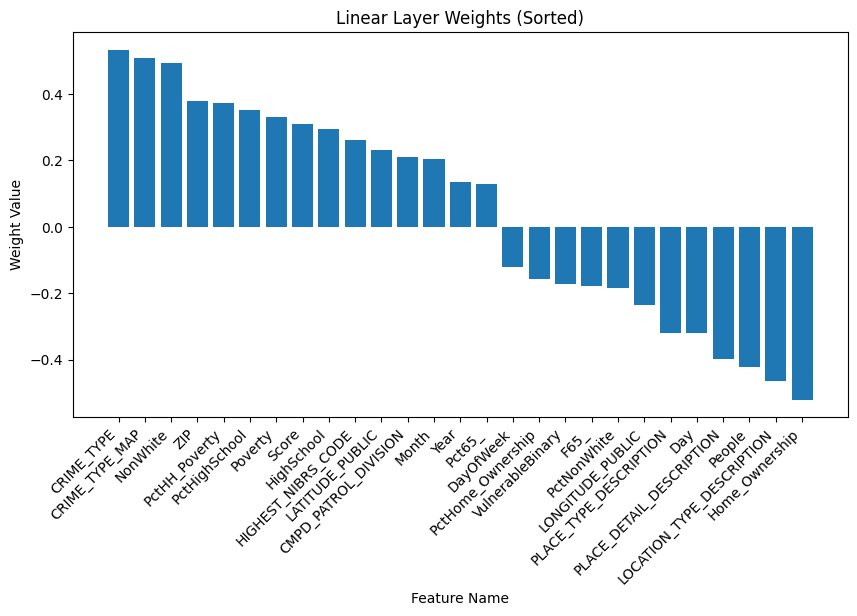

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43590
           1       0.99      1.00      0.99     11147

    accuracy                           1.00     54737
   macro avg       1.00      1.00      1.00     54737
weighted avg       1.00      1.00      1.00     54737



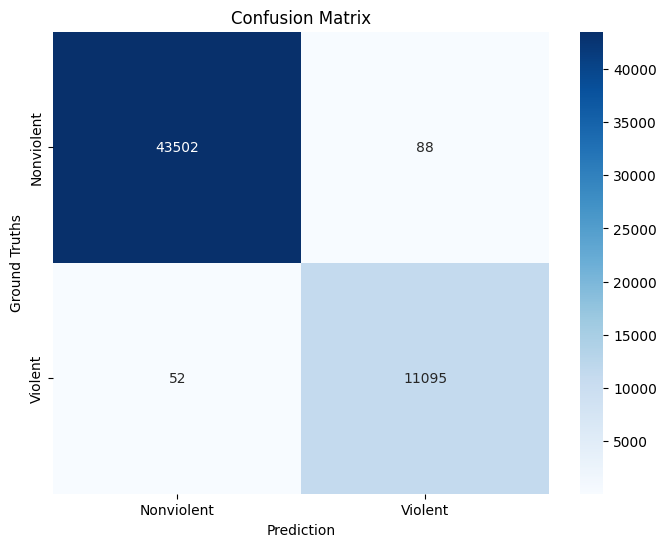

In [50]:
prediction_df = pd.DataFrame({
    'ZIP': x_test[:, 0],
    'LATITUDE_PUBLIC': x_test[:, 1],
    'LONGITUDE_PUBLIC': x_test[:, 2],
    'Violent-Crime': all_predictions
})

feature_names = df.columns

# assumes linear layer named fc
linear_weights = model.fc.weight.detach().cpu().numpy().flatten()
linear_weights = linear_weights[:input_size]

weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': linear_weights})
weights_df = weights_df.sort_values(by='Weight', ascending=False)

# plot
plt.figure(figsize=(10, 5))
plt.bar(weights_df['Feature'], weights_df['Weight'])
plt.xlabel('Feature Name')
plt.ylabel('Weight Value')
plt.title('Linear Layer Weights (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.show()

matrix = confusion_matrix(y_test, all_predictions)

report = classification_report(y_test, all_predictions, zero_division=1)

print(report)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Nonviolent', 'Violent'], yticklabels=['Nonviolent', 'Violent'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truths')
plt.title('Confusion Matrix')
plt.show()

##Multi Spatiotemporal

In [51]:
Y = df[['CRIME_TYPE', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP']]
y = df['CRIME_TYPE_MAP'].values

df = df.drop(columns=['CRIME_TYPE', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP'])

x = df.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
X_train = StandardScaler().fit_transform(x_train)
X_test = StandardScaler().fit_transform(x_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [52]:
# dataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class SpatiotemporalModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SpatiotemporalModel, self).__init__()
        self.conv1d = nn.Conv1d(input_size, 32, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(32, 50, batch_first=True)
        self.fc = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)
        x = F.relu(self.conv1d(x))
        x, _ = self.lstm(x.permute(0, 2, 1))
        x = x[:, -1, :]
        x = self.fc(x)
        return x

# 8 classes
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
model = SpatiotemporalModel(input_size, output_size).to(device)

# CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop
epochs = 50
start_time = time.time()
for epoch in range(epochs):

    # training mode
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    all_predictions = []

    # evaluation mode
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted_labels = torch.max(outputs, 1)
            all_predictions.extend(predicted_labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()

    val_accuracy = correct / total

    if epoch % 5 == 0:
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch + 1}/{epochs}, Time: {epoch_time:.2f}s, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/50, Time: 14.48s, Validation Accuracy: 0.5304
Epoch 6/50, Time: 90.23s, Validation Accuracy: 0.5444
Epoch 11/50, Time: 164.91s, Validation Accuracy: 0.5494
Epoch 16/50, Time: 240.87s, Validation Accuracy: 0.5513
Epoch 21/50, Time: 319.14s, Validation Accuracy: 0.5512
Epoch 26/50, Time: 395.83s, Validation Accuracy: 0.5514
Epoch 31/50, Time: 472.99s, Validation Accuracy: 0.5514
Epoch 36/50, Time: 547.63s, Validation Accuracy: 0.5509
Epoch 41/50, Time: 621.34s, Validation Accuracy: 0.5505
Epoch 46/50, Time: 696.49s, Validation Accuracy: 0.5507


              precision    recall  f1-score   support

           0       0.47      0.36      0.41     10590
           1       0.61      0.67      0.64     19409
           2       0.54      0.85      0.66     13605
           3       0.26      0.00      0.01      4924
           4       0.65      0.17      0.27       749
           5       0.27      0.01      0.01      1700
           6       0.42      0.41      0.41      2868
           7       0.60      0.28      0.38       892

    accuracy                           0.55     54737
   macro avg       0.48      0.35      0.35     54737
weighted avg       0.51      0.55      0.50     54737



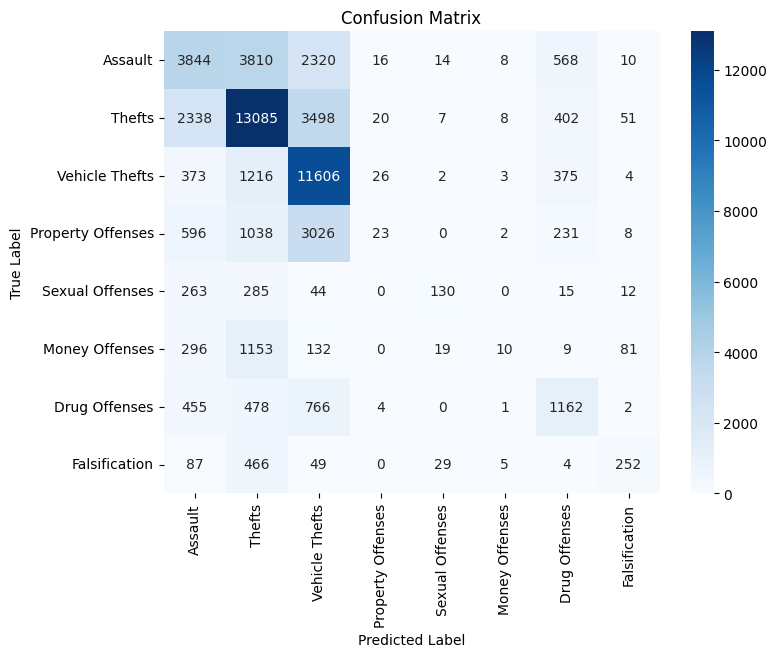

In [53]:
# DataFrame
prediction_df = pd.DataFrame({
    'ZIP': x_test[:, 0],
    'LATITUDE_PUBLIC': x_test[:, 1],
    'LONGITUDE_PUBLIC': x_test[:, 2],
    'CRIME_TYPE_MAP': all_predictions
})

# mapping dictionary
mapping_dict = {
    0: 'Assault',
    1: 'Thefts',
    2: 'Vehicle Thefts',
    3: 'Property Offenses',
    4: 'Sexual Offenses',
    5: 'Money Offenses',
    6: 'Drug Offenses',
    7: 'Falsification'
}

prediction_df['PREDICTED_CRIME_TYPE'] = prediction_df['CRIME_TYPE_MAP'].map(mapping_dict)

crime_types = ['Assault', 'Thefts', 'Vehicle Thefts', 'Property Offenses', 'Sexual Offenses', 'Money Offenses', 'Drug Offenses', 'Falsification']

y_test_np = y_test_tensor.cpu().numpy()
all_predictions_np = np.array(all_predictions)

conf_matrix = confusion_matrix(y_test_np, all_predictions_np)

report = classification_report(y_test_np, all_predictions_np, zero_division=1)
print(report)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=crime_types, yticklabels=crime_types)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()